# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors
from functools import partial

from IPython.display import clear_output
from ocp import *
#from costs import *
import pdb
from utils import subsample

from scipy.optimize import fmin
import crocoddyl

from ocp_sys import *


np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

In [2]:
from casadi import mtimes, MX, sin, cos, vertcat, horzcat, sum1, cross, Function, jacobian, solve
import casadi


In [3]:
from ocp import *

In [4]:
%matplotlib inline

In [5]:
class Biped_Casadi():
    def __init__(self, m1 = 7, m2 = 7, m3 = 17,
                l1 = 0.5, l2 = 0.5, l3 = 0.35, g = 9.81, dT = 0.001, control_opt = 'std'):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.g = g
        self.dT = dT
        self.control_parameters = np.array([457.5, 161, 77.05, 5, 10.4*np.pi/180])  
        self.control_opt = control_opt
        self.Dx = 6
        self.Du = 2
        
        self.x = MX.sym('x', self.Dx)
        self.u = MX.sym('u', self.Du)
       
    def set_control(self, control_opt = 'std', ilqr = None, xs_ref = None, ddqs_ref = None, Kp = 100*np.eye(3), Kd = 100*np.eye(3), Q = 100*np.eye(3), max_control = 60):
        self.control_opt = control_opt
        if control_opt == 'ilqr':
            self.ilqr = ilqr
        elif control_opt == 'qp':
            self.ilqr = ilqr
            self.xs_ref = xs_ref
            self.Kp = Kp
            self.Kd = Kd
            self.Q = Q
            self.max_control = max_control
            self.ddqs_ref = ddqs_ref
            
    def compute_Jacobian_swf(self, q, dq = None):
        J = np.zeros((2,3))
        J[0,0] = self.l1*cos(q[0])
        J[0,1] = -self.l2*cos(q[1])
        J[1,0] = -self.l1*sin(q[0])
        J[1,1] = self.l2*sin(q[1])
        return J
    def compute_Jacobian_vhip(self, q, dq):
        J = np.zeros((2,6))
        J[0,0] = -self.l1*sin(q[0])*dq[0]
        J[0,3] = self.l1*cos(q[0])
        J[1,0] = -self.l1*cos(q[0])*dq[0]
        J[1,3] = -self.l1*sin(q[0])
        return J

    def eval_energy(self, q, dq):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        T = (dq1**2*l1**2*m1)/8 + (dq1**2*l1**2*m2)/2 + (dq1**2*l1**2*m3)/2 + (dq2**2*l2**2*m2)/8 + (dq3**2*l3**2*m3)/8 - (dq1*dq2*l1*l2*m2*cos(q1 - q2))/2 + (dq1*dq3*l1*l3*m3*cos(q1 - q3))/2;
        V = g*m2*(l1*cos(q1) - (l2*cos(q2))/2) + g*m3*(l1*cos(q1) + (l3*cos(q3))/2) + (g*l1*m1*cos(q1))/2;
        return T, V

    def kin_hip(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_h = self.l1*sin(q[0])  
        z_h = self.l1*cos(q[0])  
        dx_h = self.l1*cos(q[0])*dq[0]  
        dz_h = -self.l1*sin(q[0])*dq[0]

        return x_h, z_h, dx_h, dz_h
    
    def kin_swf(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_swf = self.l1*sin(q[0]) - self.l2*sin(q[1])  
        z_swf = self.l1*cos(q[0]) - self.l2*cos(q[1])
        dx_swf = self.l1*cos(q[0])*dq[0] - self.l2*cos(q[1])*dq[1]  
        dz_swf = -self.l1*sin(q[0])*dq[0] + self.l2*sin(q[1])*dq[1]
        return x_swf, z_swf, dx_swf, dz_swf
    
    
    def eval_A_m(self, q_m):
        t2 = q_m[0]-q_m[1]
        t3 = cos(t2)
        t4 = self.l1**2
        t5 = self.m1*t4*0.25
        t6 = q_m[0] - q_m[2]
        t7 = cos(t6)
        t8 = self.l3**2
        m, m3 = self.m1, self.m3
        l1,l2,l3 = self.l1, self.l2, self.l3
        A_m = vertcat(t5-l1*l2*m*t3-l1*l2*m3*t3-l1*l3*m3*t7*(1.0/2.0), 
                        t5,l1*l3*m3*t7*(-1.0/2.0),l2**2*m*(1.0/4.0),0.0,0.0,\
                        m3*t8*(-1.0/4.0)-l2*l3*m3*cos(q_m[1]-q_m[2])*(1.0/2.0),\
                        0.0,m3*t8*(-1.0/4.0)).reshape((3,3))
        return A_m
    
    def eval_A_p(self, q_p):
        q1_p = q_p[0]
        q2_p = q_p[1]
        q3_p = q_p[2]
        m, m3, l1, l2, l3 = self.m1, self.m3, self.l1, self.l2, self.l3
        
        t2 = l1**2;
        t3 = q1_p-q2_p;
        t4 = cos(t3);
        t5 = l1*l2*m*t4*(1.0/2.0);
        t6 = q1_p-q3_p;
        t7 = cos(t6);
        t8 = l2**2;
        t9 = l3**2;
        A_p = vertcat(t5-m*t2*(5.0/4.0)-m3*t2-l1*l3*m3*t7*(1.0/2.0),t5,l1*l3*m3*t7*(-1.0/2.0),t5-m*t8*(1.0/4.0),
                       m*t8*(-1.0/4.0),0.0,m3*t9*(-1.0/4.0)-l1*l3*m3*t7*(1.0/2.0),0.0,m3*t9*(-1.0/4.0)).reshape((3,3))
        return A_p
    
    def eval_B(self, mode = 'casadi'):
        if mode == 'casadi':
            B = vertcat(1.0,0.0,0.0, 1.0,-1.0,-1.0).reshape((2,3)).T
        elif mode == 'numpy':
            B = np.array([1.0,0.0,0.0, 1.0,-1.0,-1.0]).reshape(3,2)
        return B
    
    def eval_C(self, q, dq, mode = 'casadi'):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3 =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3

        t2 = q1-q2
        t3 = sin(t2)
        t4 = q1-q3
        t5 = sin(t4)
        if mode == 'casadi':
            C = vertcat(0.0,dq1*l1*l2*m2*t3*(1.0/2.0),dq1*l1*l3*m3*t5*(-1.0/2.0),
                      dq2*l1*l2*m2*t3*(-1.0/2.0),0.0,0.0,dq3*l1*l3*m3*t5*(1.0/2.0),0.0,0.0).reshape((3,3))
        elif mode == 'numpy':
            C = np.array([0.0,dq1*l1*l2*m2*t3*(1.0/2.0),dq1*l1*l3*m3*t5*(-1.0/2.0),
                      dq2*l1*l2*m2*t3*(-1.0/2.0),0.0,0.0,dq3*l1*l3*m3*t5*(1.0/2.0),0.0,0.0]).reshape(3,3).T
        return C
        
    
    def eval_G(self, q, mode = 'casadi'):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g
        
        if mode == 'casadi':
            G = vertcat(g*l1*sin(q1)*(m1+m2*2.0+m3*2.0)*(-1.0/2.0)
                          ,g*l2*m2*sin(q2)*(1.0/2.0),g*l3*m3*sin(q3)*(-1.0/2.0))
        elif mode == 'numpy':
            G = np.array([g*l1*sin(q1)*(m1+m2*2.0+m3*2.0)*(-1.0/2.0)
                          ,g*l2*m2*sin(q2)*(1.0/2.0),g*l3*m3*sin(q3)*(-1.0/2.0)])
            
        return G
    
    def eval_M(self, q, mode = 'casadi'):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        t2 = q1-q2;
        t3 = cos(t2);
        t4 = q1-q3;
        t5 = cos(t4);
        t6 = l1*l3*m3*t5*(1.0/2.0);
        if mode == 'casadi':
            M = vertcat(l1**2*(m1*(1.0/4.0)+m2+m3),l1*l2*m2*t3*(-1.0/2.0),
                          t6,l1*l2*m2*t3*(-1.0/2.0),l2**2*m2*(1.0/4.0),0.0,
                          t6,0.0,l3**2*m3*(1.0/4.0)).reshape((3,3)).T
        elif mode == 'numpy':
            M = np.array([l1**2*(m1*(1.0/4.0)+m2+m3),l1*l2*m2*t3*(-1.0/2.0),
                          t6,l1*l2*m2*t3*(-1.0/2.0),l2**2*m2*(1.0/4.0),0.0,
                          t6,0.0,l3**2*m3*(1.0/4.0)]).reshape(3,3)
            
        return M
    
    def impact(self, q_m, dq_m):
        q_p = np.array([q_m[1], q_m[0], q_m[2]])
        A_m = self.eval_A_m(q_m)
        A_p = self.eval_A_p(q_p)
        dq_p = np.linalg.pinv(A_p).dot(A_m).dot(dq_m)
        return q_p, dq_p
    
    def step_cas(self, y, u):
        #step using Euler integration
        q = y[:3]
        dq = y[3:]
        M = self.eval_M(q)
        C = self.eval_C(q, dq)
        G = self.eval_G(q)
        B = self.eval_B()
        dy = vertcat( y[3:], solve(M, -mtimes(C,dq) - G + mtimes(B,u)))
        ynext = y + dy*self.dT
        return ynext

    def step(self, y, u):
        #step using Euler integration
        q = y[:3]
        dq = y[3:]
        mode = 'numpy'
        M = self.eval_M(q, mode)
        C = self.eval_C(q, dq, mode)
        G = self.eval_G(q, mode)
        B = self.eval_B(mode)
        dy = np.concatenate([ y[3:], np.linalg.solve(M, -C.dot(dq) - G + B.dot(u))])
        ynext = y + dy*self.dT
        return ynext
    
    def def_compute_matrices(self):
        self.ynext = self.step_cas(self.x, self.u)
        self.A = jacobian(self.ynext, self.x)
        self.B = jacobian(self.ynext, self.u)
        self.A_val = Function('A', [self.x,self.u], [self.A])
        self.B_val = Function('B', [self.x,self.u], [self.B])
        
    def compute_matrices(self,x,u):
        A = np.array(self.A_val(x,u))
        B = np.array(self.B_val(x,u))
        return A, B
    
            
    
    def visualize(self, q, r0 = None, fig = None, figsize = (10,10)):
        if fig is None:     
            if self.fig is None: self.fig = plt.figure(figsize=figsize)
        else:
            self.fig = fig
        if r0 is None: r0 = np.zeros(2)

        x0 = r0[0];
        z0 = r0[1];

        l1, l2, l3 = self.l1, self.l2, self.l3 
        q1, q2, q3 = q[0], q[1], q[2]

        x1 = (l1*sin(q1))/2 + x0;
        z1 = (l1*cos(q1))/2 + z0;
        x2 = l1*sin(q1) - (l2*sin(q2))/2 + x0;
        z2 = l1*cos(q1) - (l2*cos(q2))/2 + z0;
        x3 = l1*sin(q1) + (l3*sin(q3))/2 + x0;
        z3 = l1*cos(q1) + (l3*cos(q3))/2 + z0;

        x_h = l1*sin(q1) + x0;
        z_h = l1*cos(q1) + z0;

        x_t = l1*sin(q1) + l3*sin(q3) + x0;
        z_t = l1*cos(q1) + l3*cos(q3) + z0;

        x_swf = l1*sin(q1) - l2*sin(q2) + x0;
        z_swf = l1*cos(q1) - l2*cos(q2) + z0;

        lw = 5;
        # links
        if self.line1 is None:
            self.line1, = plt.plot([x0, x_h], [z0, z_h], linewidth = lw); 
            self.line2, = plt.plot([x_h, x_t], [z_h, z_t], linewidth = lw); 
            self.line3, = plt.plot([x_h, x_swf], [z_h, z_swf], linewidth = lw);
            # plot a line for "ground"
            self.lineg, = plt.plot([-1 + x_h, 1 + x_h], [0, 0], 'b');
            plt.axis('equal')
            plt.xlim([-1 + x_h, 1 + x_h]);
            plt.ylim([-0.8, 1.2]);
            # point masses
            mz = 15;
            self.marker1, = plt.plot(x1, z1, '.', markersize = mz); 
            self.marker2, = plt.plot(x2, z2, '.',  markersize = mz); 
            self.marker3, = plt.plot(x3, z3, '.',  markersize = mz);
        else:
            self.line1.set_xdata([x0, x_h])
            self.line1.set_ydata([z0, z_h])
            self.line2.set_xdata([x_h, x_t])
            self.line2.set_ydata([z_h, z_t])
            self.line3.set_xdata([x_h, x_swf])
            self.line3.set_ydata([z_h, z_swf])
            self.marker1.set_xdata(x1)
            self.marker1.set_ydata(z1)
            self.marker2.set_xdata(x2)
            self.marker2.set_ydata(z2)
            self.marker3.set_xdata(x3)
            self.marker3.set_ydata(z3)          
            self.lineg.set_xdata( [-1 + x_h, 1 + x_h])
            self.lineg.set_ydata( [0, 0])
            plt.xlim([-1 + x_h, 1 + x_h]);
            self.fig.canvas.draw()
            plt.pause(1e-6)
            self.fig.canvas.flush_events()
        
    def animate(self, sln, dt = 0.01, skip = 10):
        tic = time.time();
        self.line1, self.line2, self.line3 = None, None, None
        self.marker1, self.marker2, self.marker3 = None, None, None
        self.fig = plt.figure(figsize=(10,10))

        num_steps = len(sln['T'])
        r0 = np.zeros(2)
        for j in range(num_steps):
            Y = sln['Y'][j]
            N = len(Y)
            for i in range(0, N, skip):
                q = Y[i, :3]
                time.sleep(dt)
                self.visualize(q, r0, fig = self.fig)
            x0, _,_,_ = self.kin_swf(q)
            r0 = r0 + np.array([x0, 0])

        toc = time.time()
        
        real_time_factor = sln['T'][-1][-1] / (toc-tic)
        print('Real time factor:{}'.format(real_time_factor))
        return real_time_factor
    
    def animate_ys(self, ys, skip = 10, dt = 0.001,figsize=(10,10)):
        fig = plt.figure(figsize = figsize)
        self.fig = fig
        self.line1 = None
        z_swfs = []
        for y in ys[::skip]:
            self.visualize(y[:3], fig=fig)
            _,z_swf,_,_ = self.kin_swf(y[:3])
            z_swfs += [z_swf]
            time.sleep(dt)
        z_swfs = np.array(z_swfs)
        return z_swfs
    
    def analyse(self, sln, parameters=None,  to_plot = True, Umax = 30):
        x_hs, dx_hs, dx_hs_mean, z_hs, dz_hs = [], [], [], [], []
        x_swfs, dx_swfs, z_swfs, dz_swfs = [], [], [], []      
        qs, dqs, us = [], [], []
        t_hs = [] #time index 
        dts, fs, ds = [], [], [] # time interval for one step, frequency and displacements
        effort = 0
        cot = 0

        num_step = len(sln['Y'])
        for i in range(num_step):
            Y, T = sln['Y'][i], sln['T'][i]
            t0 = T[0]
            t_hs += [T]
            dt = T[-1] - T[0]
            dts += [dt]
            fs += [1.0/dt]

            for j in range(len(Y)):
                y, t = Y[j], T[j]
                
                x_h, z_h, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
                x_hs += [x_h]
                dx_hs += [dx_h]
                z_hs += [z_h]
                dz_hs += [dz_h]

                x_swf, z_swf, dx_swf, dz_swf =  self.kin_swf(y[:3], y[3:])
                x_swfs += [x_swf]
                dx_swfs += [dx_swf]
                z_swfs += [z_swf]
                dz_swfs += [dz_swf]
                
                qs += [y[:3]]
                dqs += [y[3:]]
                if self.control_opt == 'std':
                    u = self.control(t, y[:3], y[3:],parameters);
                elif self.control_opt == 'ilqr':
                    u = self.control_ilqr(t, y, t0);
                elif self.control_opt == 'qp':
                    u = self.control_qp(t, y, t0);
                    
                    
                us += [u]

            x_h0, _, _, _ =  self.kin_hip(Y[0][:3], Y[0][3:])
            x_hT, _, _, _ =  self.kin_hip(Y[-1][:3], Y[-1][3:])
            d = x_hT - x_h0
            ds += [d]
            dx_hs_mean += [d/dt]

        results = dict();
        results['x_h'], results['dx_h'], results['z_h'], results['dz_h'], results['dx_hs_mean']  = np.array(x_hs), np.array(dx_hs), np.array(z_hs), np.array(dz_hs), np.array(dx_hs_mean)
        results['x_swf'], results['dx_swf'], results['z_swf'], results['dz_swf']  = np.array(x_swfs), np.array(dx_swfs), np.array(z_swfs), np.array(dz_swfs)
        results['t_h'] = np.concatenate(t_hs)
        
        results['qs'], results['dqs'], results['us']  = np.array(qs), np.array(dqs), np.array(us)
        results['dts'], results['fs'], results['ds'] = np.array(dts), np.array(fs), np.array(ds)
        T = results['t_h'][-1]
        results['total_mean_velocity'] = np.sum(results['ds'])/T
        results['last_mean_velocity'] = results['ds'][-1]/results['dts'][-1]
        results['effort'] = np.sum(results['us'][:,0]**2 + results['us'][:,1]**2)/(2*T*Umax)
        results['cot'] = results['effort']/np.sum(results['ds'])
        
        if to_plot:
            fig, axs = plt.subplots(4, 5, figsize=(20,25))

            axs[0,0].plot(results['t_h'], (results['x_h']))
            axs[0,0].set_title('xh')
            axs[0,1].plot(results['t_h'], (results['dx_h']))
            axs[0,1].set_title('dxh')
            axs[0,2].plot(results['t_h'], (results['z_h']))
            axs[0,2].set_title('zh')
            axs[0,3].plot(results['t_h'], (results['dz_h']))
            axs[0,3].set_title('dzh')
            axs[0,4].plot(results['dx_hs_mean'])
            axs[0,4].set_title('dxh_mean')
            
            axs[1,0].plot(results['t_h'], (results['x_swf']))
            axs[1,0].set_title('x_swf')
            axs[1,1].plot(results['t_h'], (results['dx_swf']))
            axs[1,1].set_title('dx_swf')
            axs[1,2].plot(results['t_h'], (results['z_swf']))
            axs[1,2].set_title('z_swf')
            axs[1,3].plot(results['t_h'], (results['dz_swf']))
            axs[1,3].set_title('dz_swf')
            
            for j in range(3):
                axs[2,j].plot(results['qs'][:,j], results['dqs'][:,j])
                axs[2,j].set_title('phase plot '+str(j))
            for j in range(2):
                axs[2,3+j].plot(results['t_h'], (results['us'][:,j]))
                axs[2,3+j].set_title('us'+str(j))
           
            axs[3,0].plot((results['dts'][1:]), '-o')
            axs[3,0].set_title('dT')
            axs[3,1].plot((results['fs'][1:]), '-o')
            axs[3,1].set_title('fs')
            axs[3,2].plot((results['ds'][0:]), '-o')
            axs[3,2].set_title('ds')
            
        print('COT: {0:.2f}, Dist: {1:.3f}, dT: {2:.3f}'.format(results['cot'], results['ds'][-1], results['dts'][-1]))
        return results
    
    
    def control(self, t, q, dq, parameters):
        kp1 = parameters[0];
        kp2 = parameters[1];
        kd1 = parameters[2];
        kd2 = parameters[3];
        alpha = parameters[4];

        y1 = q[2]-alpha;
        y1d = dq[2];
        y2 = -q[1]-q[0];
        y2d = -dq[1]-dq[0];

        u1 = kp1*y1 + kd1*y1d;
        u2 = kp2*y2 + kd2*y2d;

        u1 = max(min(u1, 30), -30) 
        u2 = max(min(u2, 30), -30) 
        u = np.array([u1, u2])
        return u
    
    def compute_control_standard(self, x0, T, params):
        #compute xs and us from standard controller
        x, us, z_swfs = x0.copy(), [], []
        x_h0, _,_,_ = self.kin_hip(x[:3])
        for k in range(T):
            u = self.control(0, x[:3], x[3:], params)
            x = self.step(x, u)
            _,z_swf,_,_ = self.kin_swf(x[:3])
            z_swfs += [z_swf]
            us += [u]
        x_hT , _,dx_hT,dz_hT = self.kin_hip(x[:3])
        dist = x_hT-x_h0
        
        us, z_swfs = np.array(us), np.array(z_swfs)
        self.set_init_state(x0)
        xs = self.rollout(us)
        #add a dummy zero control at the end
        us = np.concatenate([us, np.zeros((1, self.Du))], axis=0)
        return xs, us, z_swfs, dist
    
    def compute_inverse_dynamics(self, ys, ddq_ds):
        N = len(ys)
        taus = []
        mode = 'numpy'
        B = self.eval_B(mode)
        for i in range(N):
            y, ddq_d = ys[i], ddq_ds[i]
            q, dq = y[:3], y[3:]
            M = self.eval_M(q, mode)
            C = self.eval_C(q, dq, mode)
            G = self.eval_G(q, mode)

            tau = np.linalg.pinv(B).dot(M.dot(ddq_d) + C.dot(dq) + G)
            taus += [tau]
        return taus
    
    def set_init_state(self,x0):
        self.x0 = x0
    
    def rollout(self,us):
        #rollout using Euler integration
        x_cur = self.x0.copy()
        xs = [x_cur]
        T = len(us)
        for i in range(T):
            x_cur = self.step(x_cur, us[i])
            xs += [x_cur]
        return np.array(xs)

    def solve_eqns(self, q0, dq0, num_steps, parameters, retrain = False, retrain_iter = 5):
        
        #options = odeset('RelTol',1e-5, 'Events', @event_func);
        h = self.dT; # time step
        tmax = 2; # max time that we allow for a single step
        tspan = np.arange(0, tmax, h)
        y0 = np.concatenate([q0, dq0])
        t0 = 0

        sln = {'T' : [], 'Y' : [], 'TE' : [], 'YE' : []}
        
        for i in range(num_steps):
            tic = time.time()
            eqns_std = partial(self.eqns, t0 = t0, parameters = parameters )
            tspan = np.arange(t0, t0+tmax-1e-4, h)
            sol = solve_ivp(eqns_std, (t0, t0+tmax),  y0, t_eval = np.arange(t0, t0+tmax-1e-4, h), events = event_func, rtol = 1e-5)            
            toc = time.time()
            sln['T'] += [sol.t]
            sln['Y'] += [sol.y.T]
            sln['TE'] += [sol.t_events]

            if np.abs(sol.t[-1]- tmax) < 1e-4:
                break

            if len(sol.t_events) == 0:
                break

            # Impact map
            q_m = sol.y.T[-1,:3]
            dq_m = sol.y.T[-1,3:]
            q_p, dq_p = self.impact(q_m, dq_m)

            y0 = np.concatenate([q_p, dq_p])
            t0 = sol.t[-1]
            tspan = np.arange(t0, t0+tmax-1e-4, h)
        return sln
    
    def clamp(self, u, u_max = 30):
        u1, u2 = u[0], u[1]
        u1 = max(min(u1, u_max), -u_max) 
        u2 = max(min(u2, u_max), -u_max) 
        u = np.array([u1, u2])
        return u
    
    def control_ilqr(self, t, y, t0):
        t_step = int((t- t0)/self.dT)
        #print(t_step)
        if t_step >= len(self.ilqr.us):
            t_step = len(self.ilqr.us)-1
        #calculate t_step based on the nearest neighbor
        #dist = np.linalg.norm(y - ilqr.xs, axis=1)
        #t_step = np.argmin(dist)
#         dist, idx = self.nn.kneighbors(y[None,:])
#         t_step = idx[0][0]
#         #print(t_step)
#         if t_step >= len(self.ilqr.K):
#             t_step = len(self.ilqr.K)-1
        u = self.ilqr.us[t_step] - self.ilqr.K[t_step].dot(y - self.ilqr.xs[t_step])    # for crocoddyl
    
        
        #u = self.ilqr.us[t_step] + self.ilqr.K[t_step].dot(y-self.ilqr.xs[t_step]) #for Teguh ilqr
        return self.clamp(u)
    
    def control_qp(self, t, y, t0):
        t_step = int((t- t0)/self.dT)
        if t_step >= len(self.xs_ref)-1:
            t_step = len(self.xs_ref)-1        
        y_ref = self.xs_ref[t_step]
        ddq_d = self.ddqs_ref[t_step]
        u = self.compute_qp(y, y_ref, ddq_d)
        return u
    
    def compute_qp(self, y, yd, ddq_d):
        q, dq, qd, dqd = y[:3], y[3:], yd[:3], yd[3:]
        qdd = ddq_d -self.Kp.dot(q-qd) - self.Kd.dot(dq-dqd)

        xd = np.concatenate([qdd, np.zeros(2)])
        Qt = np.eye(5)*1e-10
        Qt[:3,:3] = self.Q

        a = xd.T.dot(Qt)

        mode = 'numpy'
        M = self.eval_M(q, mode)
        C = self.eval_C(q, dq, mode)
        G = self.eval_G(q, mode)
        B = self.eval_B(mode)
        
        #use inverse dynamics instead
        tau = np.linalg.pinv(B).dot(M.dot(qdd) + C.dot(dq) + G)
        #return tau
        #pdb.set_trace()
        
        Ct = np.hstack([M, -B]).T
        Et = np.zeros((5,4))
        Et[3,0] = 1
        Et[3,1] = -1
        Et[3,2] = 1
        Et[3,3] = -1
        Ct = np.hstack([Ct, Et])

        dt = -self.max_control*np.ones(4)
        bt = -C.dot(dq) - G
        bt = np.concatenate([bt, dt])
        #print(Qt)
        x = quadprog.solve_qp(Qt, a, Ct, bt, meq = 3)
        #print('x qp:', x)
        return x[0][-2:]
        
        return tau
    
    def eqns(self, t, y, t0,  parameters = None):    
        q = y[:3]
        dq = y[3:]
        
        mode = 'numpy'
        M = self.eval_M(q, mode)
        C = self.eval_C(q, dq, mode)
        G = self.eval_G(q, mode)
        B = self.eval_B(mode)
        
        
        if self.control_opt == 'std':
            u = self.control(t, q, dq, parameters)
        elif self.control_opt == 'ilqr':
            u = self.control_ilqr(t, y, t0)
        elif self.control_opt == 'qp':
            u = self.control_qp(t, y, t0)
        n = 6
        dy = np.zeros(n)
        dy[:3] = y[3:]
        #dy[3:] = np.linalg.inv(M).dot(-C.dot(dq) - G + B.dot(u))
        dy[3:] = np.linalg.solve(M, -C.dot(dq) - G + B.dot(u))
        return dy
    
    def compute_ddq(self, y, u):
        #step using Euler integration
        q = y[:3]
        dq = y[3:]
        mode = 'numpy'
        M = self.eval_M(q, mode)
        C = self.eval_C(q, dq, mode)
        G = self.eval_G(q, mode)
        B = self.eval_B(mode)
        dy = np.zeros(6)
        dy[:3] = y[3:]
        dy[3:] = np.linalg.solve(M, -C.dot(dq) - G + B.dot(u))
        return dy


## Part 1: Standard Controller 

#### Try solving and analyse result

In [6]:
%matplotlib qt

biped = Biped_Casadi()
biped.def_compute_matrices()

COT: 1744.10, Dist: 0.331, dT: 0.383


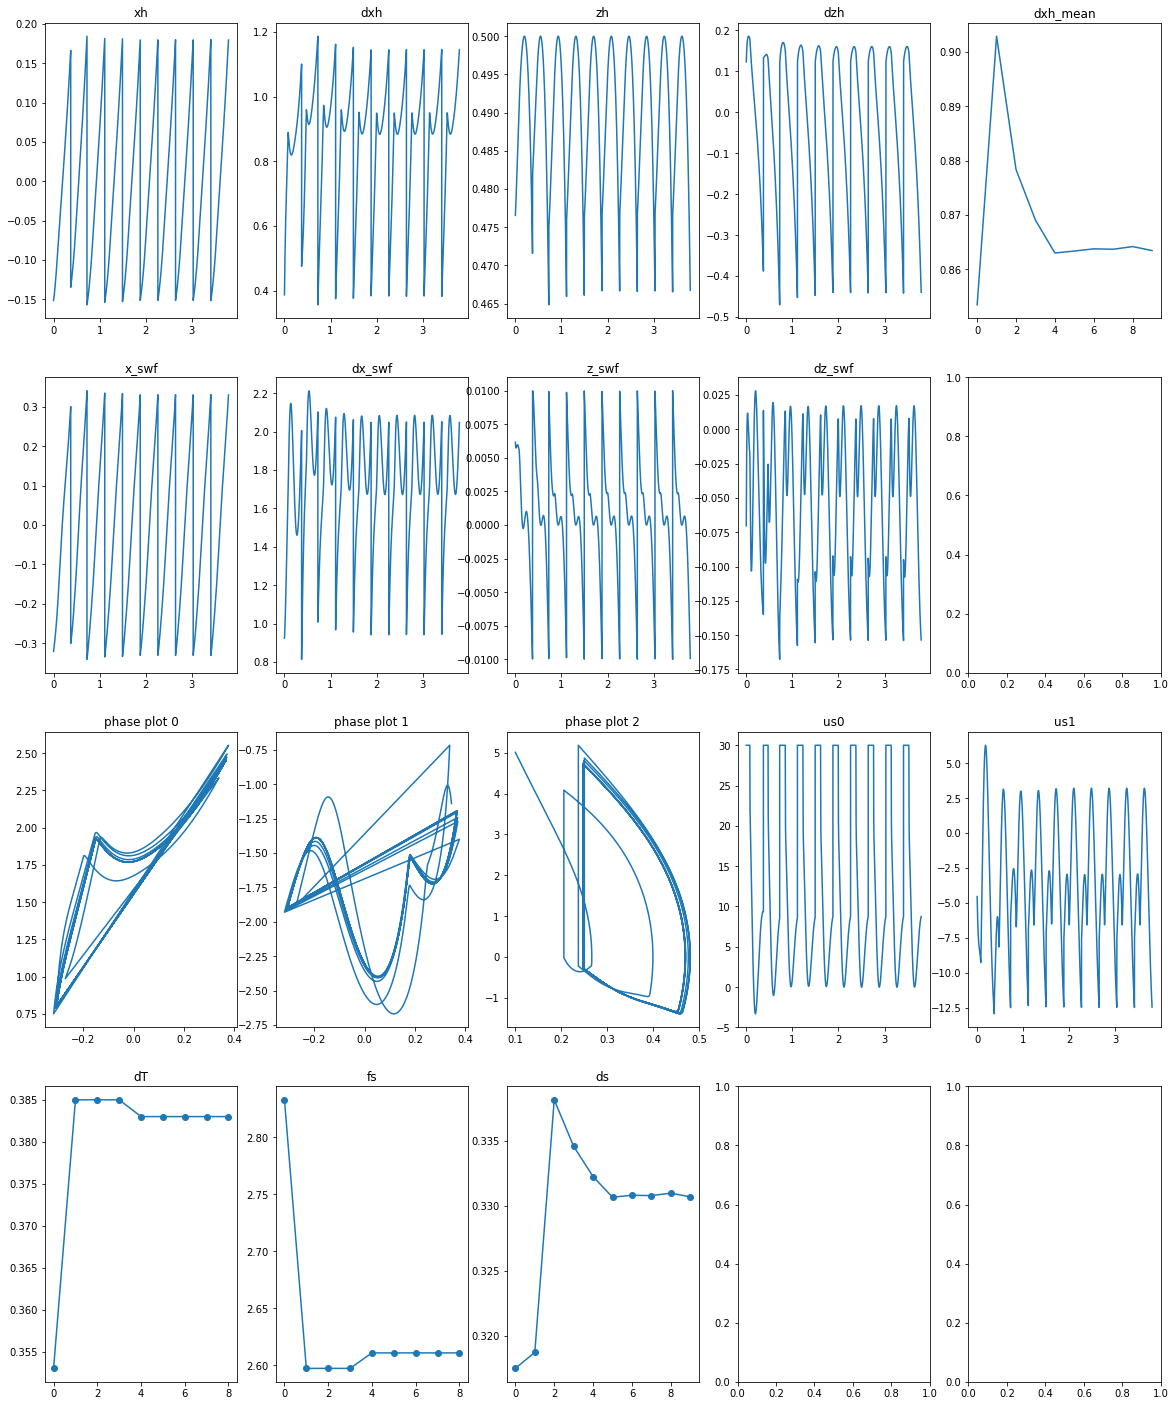

In [7]:
#standard values with standard params
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

#standard values with already stable limit cycle
# q0, dq0 = (np.array([-0.3035,  0.3608,  0.2487]), np.array([ 0.8319, -1.1396,  4.6439]))
# qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
# T = int(0.375/biped.dT)

# #standard values with already (almost) stable limit cycle for ilqr
#q0, dq0 = (np.array([-0.3075,  0.3459,  0.2666]), np.array([ 0.8131, -1.1405,  5.0078]))
q0, dq0 = (np.array([-0.3075,  0.3459,  0.1]), np.array([ 0.8131, -1.1405,  5.0078]))
qT, dqT = (np.array([ 0.3623, -0.3046,  0.2487]), np.array([ 2.4543, -1.8658, -0.2872]))
#(array([-0.3025,  0.3241,  0.233 ]), array([ 0.8955, -1.4391,  4.6021]))
#(array([-0.3038,  0.3368,  0.2396]), array([ 0.8731, -1.3125,  4.6623]))
T = int(0.375/biped.dT)

sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)
clear_output()

#biped.animate(sln, dt = 0.001)
%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, to_plot=True)

xs_std, us_std = np.hstack([res['qs'], res['dqs']]), res['us']
ddqs_std = np.array(np.gradient(xs_std, axis=0))[:,3:]/biped.dT

#### Try optimizing

In [9]:
def opt_func(opt_parameters, num_steps):
    print(num_steps)
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    x = opt_parameters[6:]

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, x);
    results = biped.analyse(sln, x, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    effort = results['effort']
    distance = np.sum(results['ds'])
    frequency = (results['fs'][-1])
    velocity = results['last_mean_velocity']
    CoT = results['cot']
    w1, w2, vd = 10, 1e-3, .9
    objective_value = w1*abs(vd - velocity) + w2*CoT + 0.3*distance
    #objective_value = velocity
    #objective_value = -np.mean(results['ds']) #+ 0.0001*CoT

    if distance < 0 or CoT < 0 or velocity < 0:
        objective_value = 1000        
    print('Obj, vel:', objective_value, velocity)
    print('Params', opt_parameters)
    return objective_value

In [10]:
#optimize
opt_parameters0 = np.concatenate([q0, dq0, biped.control_parameters])
res = fmin(opt_func, opt_parameters0, args = (10,), disp=1, full_output=True, maxiter = 100)

10
COT: 1744.10, Dist: 0.331, dT: 0.383
('Obj, vel:', 3.098008434662689, 0.8634670115779147)
('Params', array([ -0.3075,   0.3459,   0.1   ,   0.8131,  -1.1405,   5.0078,
       457.5   , 161.    ,  77.05  ,   5.    ,   0.1815]))
10
COT: 1736.02, Dist: 0.330, dT: 0.382
('Obj, vel:', 3.0799453833379236, 0.8642053939661435)
('Params', array([ -0.3229,   0.3459,   0.1   ,   0.8131,  -1.1405,   5.0078,
       457.5   , 161.    ,  77.05  ,   5.    ,   0.1815]))
10
COT: 1746.93, Dist: 0.331, dT: 0.383
('Obj, vel:', 3.092057710626267, 0.8643234041994388)
('Params', array([ -0.3075,   0.3632,   0.1   ,   0.8131,  -1.1405,   5.0078,
       457.5   , 161.    ,  77.05  ,   5.    ,   0.1815]))
10
COT: 1746.13, Dist: 0.331, dT: 0.383
('Obj, vel:', 3.0991502957589274, 0.863534522047757)
('Params', array([ -0.3075,   0.3459,   0.105 ,   0.8131,  -1.1405,   5.0078,
       457.5   , 161.    ,  77.05  ,   5.    ,   0.1815]))
10
COT: 1746.70, Dist: 0.330, dT: 0.382
('Obj, vel:', 3.0933976850406575, 0.864

In [11]:
#extract the optimization result
opt_params = res[0]
#opt_params = np.
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]

#run simulation using the optimized parameters
sln = biped.solve_eqns(q0, dq0, 20, params);
%matplotlib qt
#biped.animate(sln)

In [ ]:
%matplotlib inline
ress = biped.analyse(sln, params, True)
print(ress['last_mean_velocity'])
print(ress['total_mean_velocity'])

In [13]:
ress['cot']

404.8528889333125

### Observe the resulting initial and final configs

COT: 1823.16, Dist: 0.321, dT: 0.346


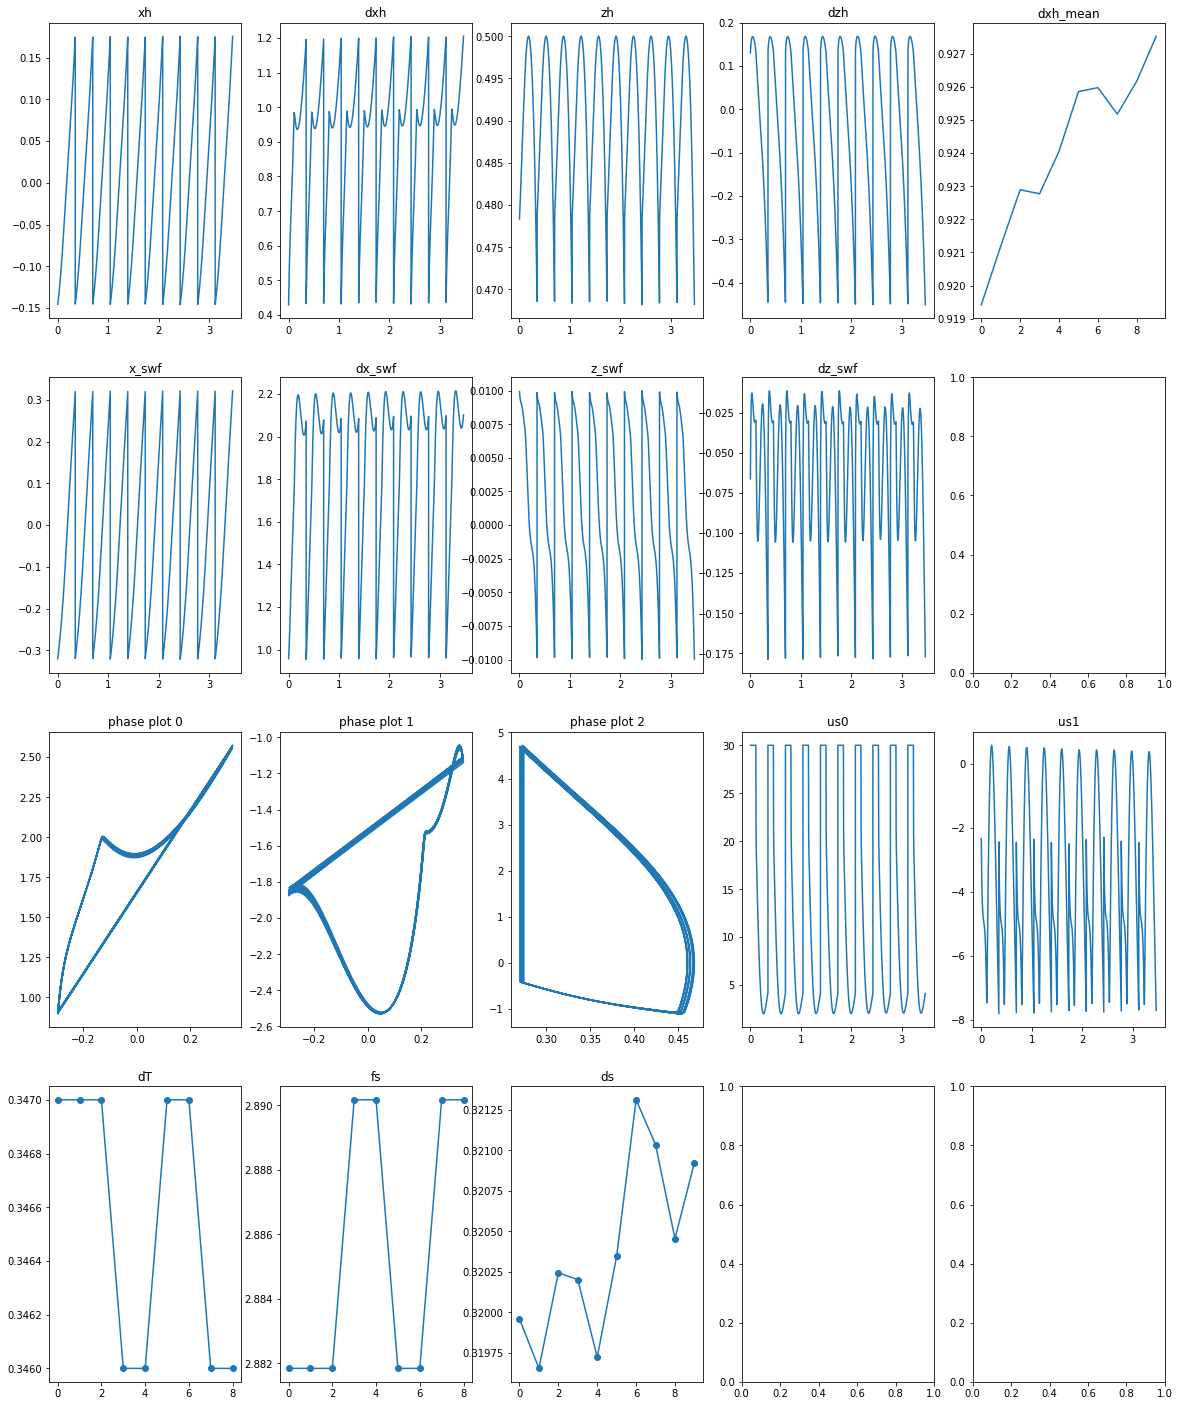

In [13]:
from utils import extract_init_goal

y0, yT = extract_init_goal(sln)
q0, dq0 = y0[-1,:3], y0[-1,3:]
qT, dqT = yT[-1,:3], yT[-1,3:]
T = sln['T'][-1][-1] - sln['T'][-1][0]
T = int(T/biped.dT)
#params = biped.control_parameters
sln = biped.solve_eqns(q0, dq0, 10, params)
clear_output()

res = biped.analyse(sln, params, to_plot=True)

In [ ]:
%matplotlib qt
biped.animate(sln)

## Part 2: Using iLQR

### One step motion using standard controller

In [14]:
x0 = np.concatenate([q0, dq0])
xT = np.concatenate([qT, dqT])
xs_init, us_init, z_swfs_init, dist_init = biped.compute_control_standard(x0, T, biped.control_parameters)

effort_init = np.sum(us_init[:,0]**2 + us_init[:,1]**2)/(2*T*biped.dT*30)
cot_init = effort_init / dist_init
print(effort_init, cot_init)

(6709.802565893895, 20974.485792916425)


### Formulate the iLQR problem

In [15]:
Tc = T #375
x_ref = xT.copy()
biped.set_init_state(x0)

#### Define cost

In [19]:
from costs import *

In [20]:
u_max = 30
step_length = 0.32

#x_ref[2] = 0.1
#standard cost on state and control
Q = np.diag([0,0,100,0,0,0])
#Q = np.diag([1,1,1,1,1,1])*0.1
Qf = np.diag([0,0,100,0,0,0])*1
#Qf = np.diag([100,100,100,100,100,100])*1000
R = np.eye(biped.Du)*.01

#swing trajectory
Wt = np.diag([0, 1e4])
z_refs = np.linspace(0.005, -0.005, Tc)

#swing foot final position
WT = np.diag([1e4, 1e5])*1
p_ref = np.array([step_length, -0.01])

# #velocity of hip
# Wv = np.diag([1e3,1e3])*0
# v_ref = np.array([.8, 0])

costs = []
for i in range(Tc):
    if i < Tc/12:
        runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
    else:
        runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
        
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    
    if i > Tc/12:
        runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    else:
        runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)
        
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
    
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
# terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
costs += [terminalCost]

#for crocoddyl
#### Setup crocoddyl model
rmodels = []
for i in range(Tc):
    state = crocoddyl.StateVector(biped.Dx)
    rmodel = ActionModelRobot(state, biped.Du)
    rmodel.init_robot_sys(biped, nr = biped.Dx)
    rmodel.set_cost(costs[i])
    rmodel.u_lb = np.array([-u_max, -u_max])
    rmodel.u_ub = np.array([u_max,u_max])
    rmodels += [rmodel]

rmodel_T = ActionModelRobot(state, biped.Du)
rmodel_T.init_robot_sys(biped, nr = biped.Dx)
rmodel_T.set_cost(terminalCost)
rmodel_T.u_lb = np.array([-u_max, -u_max])
rmodel_T.u_ub = np.array([u_max,u_max])

problem = crocoddyl.ShootingProblem(x0, rmodels, rmodel_T)

#### Initialization

In [21]:
init_types = ['control_std', 'inv_dyn', 'zeros']
init_type = 1
if init_type == 0:
    xs_init, us_init,_,_ = biped.compute_control_standard(x0, Tc, biped.control_parameters)
elif init_type == 1:
    xs_init = np.array([x0]*(Tc+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((Tc+1, 3))))
    biped.set_init_state(x0)
    #xs_init = biped.rollout(us_init)
elif init_type == 2:
    us_init = np.zeros((Tc+1, biped.Du))
    biped.set_init_state(x0)
    xs_init = biped.rollout(us_init[:-1])
    
%matplotlib qt 
#biped.animate_ys(xs_init)

In [22]:
ddp = crocoddyl.SolverBoxFDDP(problem)

ddp.th_grad = 1e-6
ddp.th_stop = 1e-6
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)

xs_ref, us_ref = np.array(ddp.xs), np.array(ddp.us)
effort_ilqr = np.sum(us_ref[:,0]**2 + us_ref[:,1]**2)/(2*T*biped.dT*30)

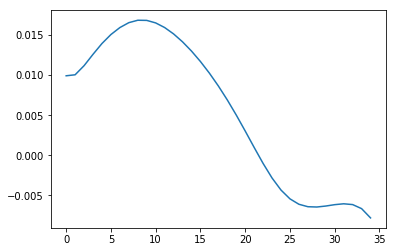

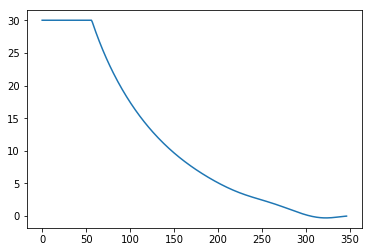

In [23]:
%matplotlib qt
z_swfs = biped.animate_ys(xs_ref)
%matplotlib inline
plt.plot(z_swfs)   
plt.figure()
plt.plot(us_ref[:,0])

#### Try simulation with ilqr

In [24]:
biped.set_control('ilqr', ddp)

In [25]:
sln = biped.solve_eqns(q0, dq0,5, biped.control_parameters)
clear_output()

In [26]:
sln['Y'][0][0]

array([-0.2954,  0.3573,  0.2699,  0.8978, -1.1256,  4.6903])

In [27]:
sln['Y'][1][0]

array([-0.2768,  0.3414,  0.3012,  0.9746, -1.0402,  4.4343])

In [28]:
%matplotlib qt
biped.animate(sln)

Real time factor:0.345402777339


0.34540277733930064

## Try optimizing

In [33]:
def opt_func_ilqr(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    y0 = np.concatenate([q0, dq0])
    #Tc = opt_parameters[6]
    alpha = opt_parameters[6]
    step_length = opt_parameters[7]

    
    #define ilqr
    #Tc = 375
    x_ref = np.array([0,0,alpha,0,0,0])
    biped.set_init_state(y0.copy())

    u_max = 30

    Q = np.diag([0,0,100,0,0,0])
    #Q = np.diag([1,1,1,1,1,1])*0.1
    Qf = np.diag([0,0,100,0,0,0])*1
    #Qf = np.diag([100,100,100,100,100,100])*1000
    R = np.eye(biped.Du)*.01

    #swing trajectory
    Wt = np.diag([0, 1e4])
    z_refs = np.linspace(0.005, -0.005, Tc)

    #swing foot final position
    WT = np.diag([1e4, 1e5])*1
    p_ref = np.array([step_length, -0.01])
    # #velocity of hip
    # Wv = np.diag([1e3,1e3])*0
    # v_ref = np.array([.8, 0])

    costs = []
    for i in range(Tc):
        if i < Tc/12:
            runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
        else:
            runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)

        runningControlCostShort = CostModelQuadratic(biped, None, R)
        p_ref_t = np.array([0, z_refs[i]])

        if i > Tc/12:
            runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
        else:
            runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)

        runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
        costs += [runningCostShort]

    terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
    terminalControlCost = CostModelQuadratic(biped, None,R)
    # terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
    terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
    terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
    costs += [terminalCost]

    #for crocoddyl
    #### Setup crocoddyl model
    rmodels = []
    for i in range(Tc):
        state = crocoddyl.StateVector(biped.Dx)
        rmodel = ActionModelRobot(state, biped.Du)
        rmodel.init_robot_sys(biped, nr = biped.Dx)
        rmodel.set_cost(costs[i])
        rmodel.u_lb = np.array([-u_max, -u_max])
        rmodel.u_ub = np.array([u_max,u_max])
        rmodels += [rmodel]

    rmodel_T = ActionModelRobot(state, biped.Du)
    rmodel_T.init_robot_sys(biped, nr = biped.Dx)
    rmodel_T.set_cost(terminalCost)
    rmodel_T.u_lb = np.array([-u_max, -u_max])
    rmodel_T.u_ub = np.array([u_max,u_max])

    problem = crocoddyl.ShootingProblem(y0, rmodels, rmodel_T)
    ddp = crocoddyl.SolverBoxFDDP(problem)

    ddp.th_grad = 1e-6
    ddp.th_stop = 1e-6
    ddp.setCallbacks([crocoddyl.CallbackVerbose()])
    
    
    #train ilqr
    xs_init = np.array([y0]*(ddp.problem.T+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((ddp.problem.T+1, 3))))
     
    ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)
    
        

    biped.set_control('ilqr', ddp)

    
    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    max_actuation = 30;
    effort = results['effort']
    distance = np.sum(results['ds'])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    print('cot:{}'.format(CoT))
    
    y0T = sln['Y'][-1][0]
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]
    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0T)
    w1 = 10
    w2 = 0.001
    vd = 0.9
    
    #objective_value = w1*abs(velocity-vd) + w2*CoT
    #objective_value = -np.mean(results['ds'][-3:])
    print('Objective: {}'.format(objective_value))
    print('Params:', opt_parameters)
    print('y0T, yn', y0T, yn)
    return objective_value

In [34]:
#biped.set_control('ilqr', ilqr)

import time
tic = time.time()
opt_parameters0 = np.concatenate([q0, dq0, np.array([0.2, 0.32])])
num_length = 1
res = fmin(opt_func_ilqr, opt_parameters0, args = (num_length,), disp=1, full_output=True, maxiter = 30)
clear_output()
toc = time.time()
print(toc-tic)
print(res[1])
print(res[0])

58.4410111904
0.03406586632221633
[-0.2902  0.3337  0.2732  0.9464 -1.1958  4.5763  0.2137  0.3031]


#### Simulation using Optimized parameters

In [65]:
opt_params = np.array([-0.3179,  0.376 ,  0.1027,  0.6033, -1.071 ,  3.7949,  0.1   ,
        0.3397]))

In [35]:
opt_params = res[0]

opt_func_ilqr(opt_params, 1)

COT: 13606.26, Dist: 0.315, dT: 0.338
cot:13606.255368
Objective: 0.0340658663222
('Params:', array([-0.2902,  0.3337,  0.2732,  0.9464, -1.1958,  4.5763,  0.2137,
        0.3031]))
('y0T, yn', array([-0.2902,  0.3337,  0.2732,  0.9464, -1.1958,  4.5763]), array([-0.2886,  0.3519,  0.262 ,  0.9247, -1.1839,  4.5856]))


0.03406586632221633

COT: 2145.82, Dist: 0.308, dT: 0.343


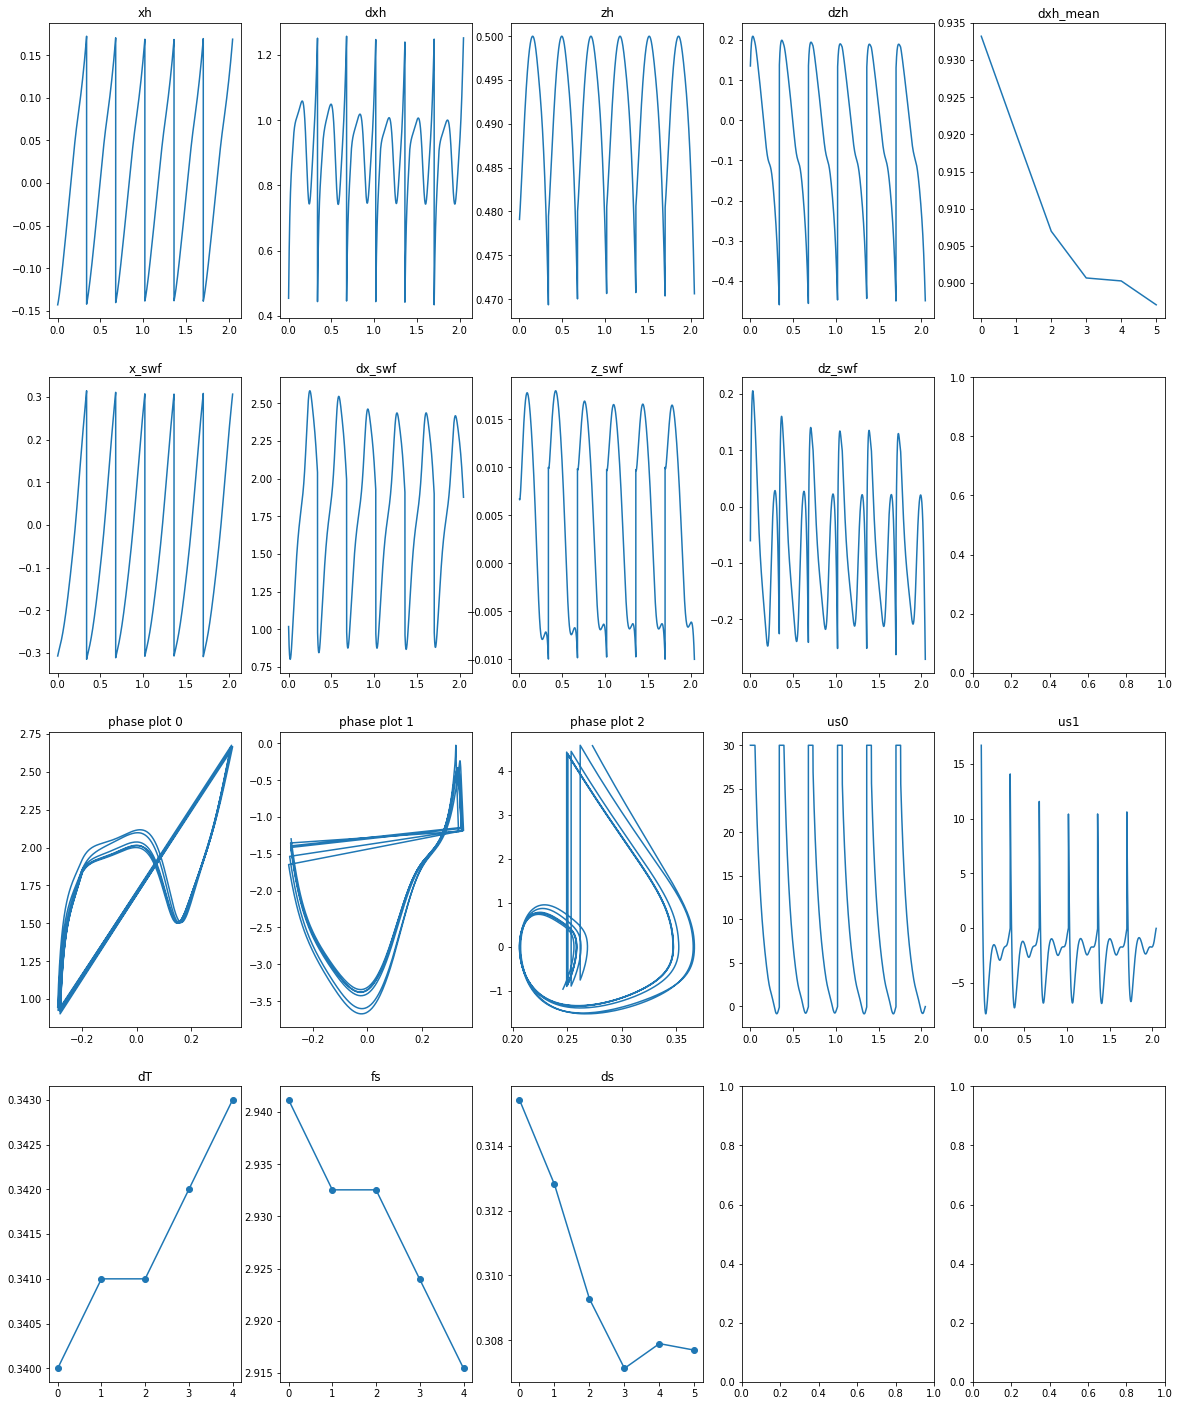

In [36]:
opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 6, params)
%matplotlib qt
clear_output()
#biped.animate(sln)
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)

In [212]:
%matplotlib qt
biped.animate(sln)

Real time factor:0.350924089108


0.3509240891081299

In [94]:
opt_params

array([-0.3179,  0.376 ,  0.1027,  0.6033, -1.071 ,  3.7949,  0.1   ,
        0.34  ])

In [97]:
ddp = biped.ilqr

In [105]:
biped.ilqr = ddp

In [106]:
xs_ilqr = np.array(ddp.xs)
ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis=0))[:,3:]*1000

In [167]:
xs_ilqr = sln['Y'][0]
ddqs_ilqr = np.array(np.gradient(xs_ilqr, axis=0))[:,3:]*1000

In [208]:
Kp = np.diag(np.array([100,30,100]))
Kd = np.diag(np.array([30,30,30]))
Q = np.diag(np.array([10,1000,100]))
biped.set_control('qp', biped.ilqr, xs_ilqr, ddqs_ilqr,  Q = Q, Kd = Kd, Kp = Kp, max_control=30)

#### Simulation using Optimized parameters

In [205]:
xs_qp = sln['Y'][2]
ddqs_qp = np.array(np.gradient(xs_qp, axis=0))[:,3:]*1000

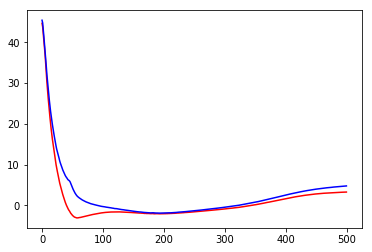

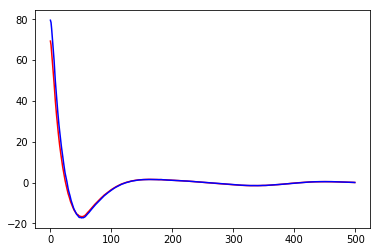

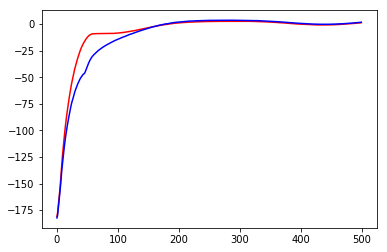

In [206]:
%matplotlib inline
for idx in range(3):
    plt.figure()
    plt.plot(ddqs_ilqr[:500,idx], 'r')
    plt.plot(ddqs_qp[:500,idx], 'b')


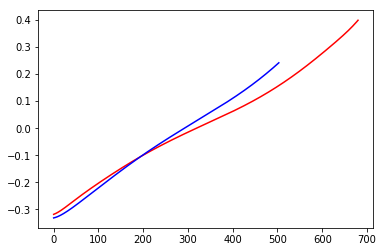

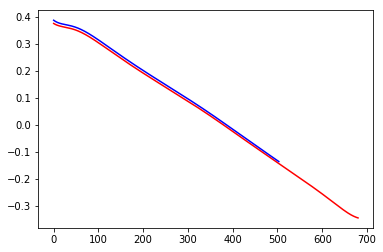

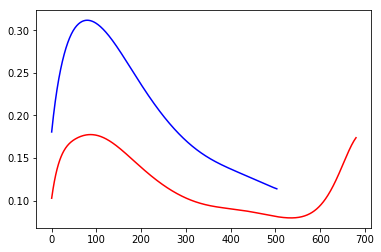

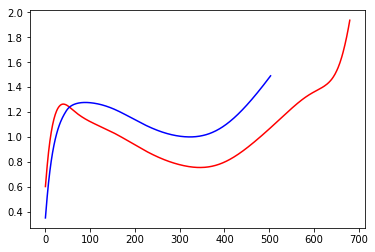

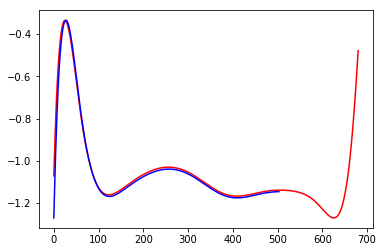

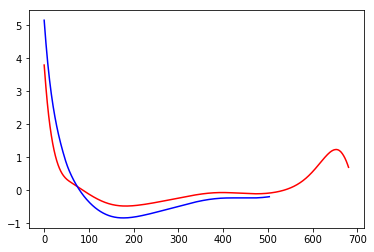

In [207]:
for idx in range(6):
    plt.figure()
    plt.plot(xs_ilqr[:,idx], 'r')
    plt.plot(xs_qp[:,idx], 'b')


In [209]:
# opt_params = res[0]
# q0 = opt_params[:3]
# dq0 = opt_params[3:6]
# params = opt_params[6:]
# params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 4, None)
%matplotlib qt
clear_output()
biped.animate(sln)

Real time factor:0.352202610869


0.3522026108685634